In [23]:
#@title Imports & Utils


!pip install jax-md
!wget https://raw.githubusercontent.com/google/jax-md/main/examples/models/sand_castle.png

import imageio
import jax.numpy as jnp

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style(style='white')
background_color = [56 / 256] * 3

def make_from_image(filename, size_in_pixels):
  position = []
  angle = []
  color = []

  img = imageio.imread(filename)

  scale = 2**(1/6)
  ratio = jnp.sqrt(1 - 0.25)
  for i, y in enumerate(range(0, img.shape[0], size_in_pixels)):
    for x in range(0, img.shape[1], size_in_pixels):
      r, g, b, a = img[y, x]
      if a == 255:
        hshift = size_in_pixels * (i % 2) / 2.0
        position += [[scale * (x + hshift) / size_in_pixels, scale * (img.shape[0] - y) / size_in_pixels * ratio]]
        color += [[r / 255, g / 255, b / 255]]
  img_size = jnp.array(img.shape[:2]).T / size_in_pixels * scale
  box_size = jnp.max(img_size) * 1.5
  position = jnp.array(position, jnp.float64) + box_size / 2.0 - img_size / 2
  color = jnp.array(color, jnp.float64)

  return box_size, position, color

Obtaining file:///Users/isaacsoh/com/github/Genentech/beignet
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for beignet (pyproject.toml) ... done
  Created wheel for beignet: filename=beignet-0.0.8.dev51-0.editable-py3-none-any.whl size=3455 sha256=893b91b51b1b376c840c6353b16c6414789db7af82ec334bad0feec42923d624
  Stored in directory: /private/var/folders/5z/n33pbk9s5vbby7s_v4vv64600000gp/T/pip-ephem-wheel-cache-8hok_hbj/wheels/28/e3/61/028d999d7774a75be5b20b748098b6761e25a7e79dd3c45658
Successfully built beignet
  Attempting uninstall: beignet
    Found existing installation: beignet 0.0.8.dev51
    Can't uninstall 'beignet'. No files were found to uninstall.


/var/folders/5z/n33pbk9s5vbby7s_v4vv64600000gp/T/ipykernel_13444/3437639023.py:7: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('pdf', 'svg')


# Sand Castle

In this demo we simulate a sand castle and then demolish it using a projectile.

## Load the sand castle

In [24]:
box, positions, colors = make_from_image('sand_castle.png', 24)

/var/folders/5z/n33pbk9s5vbby7s_v4vv64600000gp/T/ipykernel_13444/3437639023.py:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(filename)


In [26]:
from jax_md.colab_tools import renderer

renderer.render(box,
                renderer.Disk(positions, color=colors))

There are 1616 grains.


In [ ]:
print(f'There are {len(positions)} grains.')

## Spaces

In [27]:
import torch
from beignet.func import space

box = torch.tensor()
displacement_fn, shift_fn = space(box)

In [28]:
positions[0]

tensor([73.9422, 62.5549])

In [29]:
displacement_fn(positions[0], positions[-1])

tensor([-27.5003,  41.7995])

In [30]:
shift_fn(positions[0], jnp.array([10.0, 0.0]))

tensor([83.9422, 62.5549])

## Energy

"Energy" in Physics plays a similar role to "Loss" in machine learning.

Write down an energy function between two grains of sand, $\epsilon(r)$.

The total energy will be the sum of all pairs of energies.

$$E = \sum_{i,j} \epsilon(r_{ij})$$

where $r_{ij}$ is the distance between grain $i$ and grain $j$.


We want to model wet sand:

*   Grains are hard (no interpenetration).
*   Grains stick together a little bit.
*   Grains far away from one another don't notice each other.

Text(0, 0.5, '$\\epsilon$')

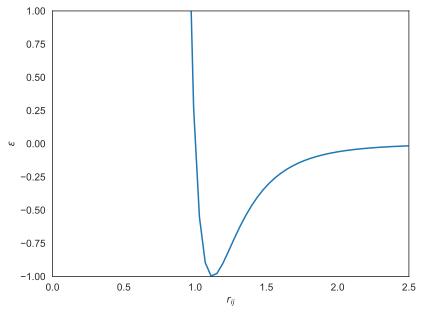

In [35]:
from jax_md import energy

rs = jnp.linspace(0.5, 2.5)
plt.plot(rs, energy.lennard_jones(rs))

plt.ylim([-1, 1])
plt.xlim([0, 2.5])
plt.xlabel('$r_{ij}$')
plt.ylabel('$\\epsilon$')

In [36]:
sand_energy = energy.lennard_jones_pair(displacement_fn)

sand_energy(positions)

tensor(-4977.0781)

## Simulate

In [44]:
from jax import random

simulation_steps = 10000
write_every = 50
key = random.PRNGKey(1)

In [45]:
from jax_md import simulate
from jax import jit

init_fn, step_fn = simulate.nvt_langevin(sand_energy, shift_fn, dt=5e-3, kT=0.0, gamma=1e-2)

sand = init_fn(key, positions)
step_fn = jit(step_fn)

In [46]:
trajectory = []

for i in range(simulation_steps):
  if i % write_every == 0:
    trajectory += [sand.position]

  sand = step_fn(sand)

trajectory = jnp.stack(trajectory)

In [47]:
renderer.render(box, renderer.Disk(trajectory, color=colors))

## Simulate slightly faster...

In [56]:
from jax import lax

def simulation_fn(i, sand_trajectory):
  sand, trajectory = sand_trajectory

  trajectory = trajectory.at[i].set(sand.position)
  sand = lax.fori_loop(0, write_every, lambda _, s: step_fn(s), sand)

  return sand, trajectory

In [57]:
write_steps = simulation_steps // write_every
n = positions.shape[0]

sand = init_fn(random.PRNGKey(0), positions)
trajectory = jnp.zeros((write_steps, n, 2))
sand, trajectory = lax.fori_loop(0, write_steps, simulation_fn, (sand, trajectory))

In [58]:
renderer.render(box, renderer.Disk(trajectory, color=colors))

## Let's blow it up!

### The projectile

Text(0, 0.5, '$\\epsilon$')

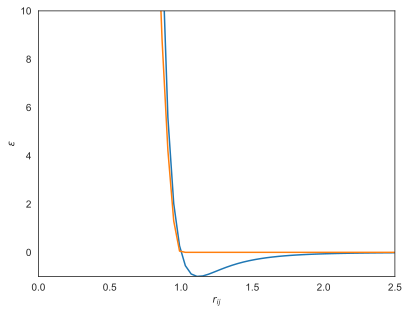

In [59]:
projectile = jnp.array([1.0, box / 3.0])

radius = jnp.array(2.0)
strength = 1000.0
velocity = jnp.array([3e-2, 0.0])

Model the projectile by adding a term to the energy,

$$E = \sum_{i,j}\epsilon(r_{ij}) + \sum_i \epsilon_p(r_{ip})$$

where $r_{ip}$ is the distance between grain $i$ and the projectile.

Want the projectile to only repel the sand (no attraction).

In [88]:
from jax_md import energy

rs = jnp.linspace(0.5, 2.5)
plt.plot(rs, energy.lennard_jones(rs))
plt.plot(rs, energy.soft_sphere(rs, epsilon=strength))

plt.ylim([-1, 10])
plt.xlim([0, 2.5])
plt.xlabel('$r_{ij}$')
plt.ylabel('$\\epsilon$')

In [89]:
def projectile_energy(sand, projectile):
  distance = jnp.linalg.norm(sand - projectile, axis=-1)
  e = energy.soft_sphere(distance, sigma=radius + 1.0, epsilon=strength)
  return jnp.sum(e)

def total_energy(sand, projectile, **kwargs):
  return sand_energy(sand) + projectile_energy(sand, projectile)

### Run the simulation

In [90]:
from jax_md import dataclasses

@dataclasses.dataclass
class SandCastle:
  sand: simulate.NVTLangevinState
  projectile: jnp.ndarray

In [91]:
simulation_steps = 10000
write_every = 50
write_steps = simulation_steps // write_every

TypeError: total_energy() missing 1 required positional argument: 'neighbor'

In [71]:
from jax_md import simulate

init_fn, step_fn = simulate.nvt_langevin(total_energy, shift_fn, dt=5e-3, kT=0.0)

In [72]:
from jax import lax

def simulation_fn(i, state_trajectory):
  state, traj = state_trajectory

  traj = SandCastle(
      traj.sand.at[i].set(state.sand.position),
      traj.projectile.at[i].set(state.projectile)
  )

  def total_step_fn(_, state):
    return SandCastle(
        step_fn(state.sand, projectile=state.projectile),
        state.projectile + velocity
    )

  state = lax.fori_loop(0, write_every, total_step_fn, state)

  return state, traj

SyntaxError: unterminated string literal (detected at line 3) (2448750232.py, line 3)

In [74]:
n = positions.shape[0]

state = SandCastle(
    init_fn(key, positions, projectile=projectile),
    projectile
)
trajectory = SandCastle(
    jnp.zeros((write_steps, n, 2)),
    jnp.zeros((write_steps, 2))
)

state, trajectory = lax.fori_loop(0, write_steps, simulation_fn, (state, trajectory))

/var/folders/5z/n33pbk9s5vbby7s_v4vv64600000gp/T/ipykernel_13444/3437639023.py:20: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(filename)


In [75]:
renderer.render(
    box,
    {
        'sand': renderer.Disk(trajectory.sand, color=colors),
        'projectile': renderer.Disk(trajectory.projectile[:, None, :],
                                    diameter=radius * 2)
    }
)

25961

## Scaling Up

So far at each step we have been computing the interaction between every pair of grains.

But grains that are far apart don't affect each other.

In [76]:
box, positions, colors = make_from_image('sand_castle.png', 6)

In [77]:
len(positions)

/Users/isaacsoh/com/github/Genentech/beignet/src/beignet/func/_partition.py:1054: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  particle_index = torch.tensor(positions / unit_size, dtype=torch.int32)


cell_capacity: 15


In [83]:
from jax_md.colab_tools import renderer

renderer.render(box, renderer.Disk(positions, color=colors))

torch.Size([2, 472671])

In [84]:
displacement_fn, shift_fn = space.periodic(box)

### Neighbor lists

In [ ]:
neighbor_fn, sand_energy = energy.lennard_jones_neighbor_list(displacement_fn, box)

In [85]:
nbrs = neighbor_fn.allocate(positions)

In [86]:
nbrs.idx.shape

In [ ]:
def total_energy(sand, projectile, neighbor, **kwargs):
  return sand_energy(sand, neighbor) + projectile_energy(sand, projectile)

### Simulation

In [ ]:
simulation_steps = 30000
write_every = 400
write_steps = simulation_steps // write_every

projectile = jnp.array([1.0, box / 3.0])
radius = jnp.array(8.0)

In [ ]:
from jax_md import partition

@dataclasses.dataclass
class SandCastle:
  sand: simulate.NVTLangevinState
  projectile: jnp.ndarray
  neighbor: partition.NeighborList

In [ ]:
from jax_md import simulate

init_fn, step_fn = simulate.nvt_langevin(total_energy, shift_fn, dt=5e-3, kT=0.0, gamma=1e-2)

In [ ]:
from jax import lax

def simulation_fn(i, state_trajectory):
  state, traj = state_trajectory

  traj = SandCastle(
     traj.sand.at[i].set(state.sand.position),
     traj.projectile.at[i].set(state.projectile),
     None
  )

  def total_step_fn(_, state):
    sand = step_fn(state.sand,
                   projectile=state.projectile,
                   neighbor=state.neighbor)
    projectile = state.projectile + velocity
    neighbor = state.neighbor.update(state.sand.position)
    return SandCastle(sand, projectile, neighbor)

  state = lax.fori_loop(0, write_every, total_step_fn, state)

  return state, traj

In [ ]:
n = positions.shape[0]

state = SandCastle(
    init_fn(random.PRNGKey(0), positions, projectile=projectile, neighbor=nbrs),
    projectile,
    nbrs
)
trajectory = SandCastle(
    jnp.zeros((write_steps, n, 2)),
    jnp.zeros((write_steps, 2)),
    None
)

state, trajectory = lax.fori_loop(0, write_steps, simulation_fn, (state, trajectory))

In [ ]:
state.neighbor.did_buffer_overflow

In [ ]:
renderer.render(
    box,
    {
        'sand': renderer.Disk(trajectory.sand, color=colors),
        'projectile': renderer.Disk(trajectory.projectile[:, None, :],
                                    diameter=radius * 2)
    },
    buffer_size=10
)